# ITE Experiment on CRITEO-ITE Dataset 

This notebook is reproducing ITE benchmark experiment conducted in Section 5.3 of the paper titled "A Large Scale Benchmark for Individual Treatment Effect Prediction and Uplift Modeling" for NeurIPS 2021 Datasets and Benchmarks Track.

## Installation

In [1]:
%%capture
!git clone https://github.com/uber/causalml.git
!cd causalml
!pip install -r requirements.txt
!pip install causalml

## Imports

In [2]:
import pickle
import numpy as np
from scipy import integrate, sparse
import pandas as pd
from tqdm import tqdm, tqdm_notebook
%pylab inline
plt.rcParams.update(plt.rcParamsDefault)
from joblib import Parallel, delayed
from time import time
import subprocess
from uuid import uuid4

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, KFold
from sklearn.preprocessing import normalize, OneHotEncoder, StandardScaler
from sklearn.feature_extraction import FeatureHasher
from sklearn.datasets import dump_svmlight_file, load_svmlight_file
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier, SGDRegressor, Lasso, Ridge
from sklearn.base import BaseEstimator
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score 
from sklearn.metrics import make_scorer, SCORERS, roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from causalml.inference.meta import BaseXRegressor


from math import factorial
from scipy.stats import mannwhitneyu

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


## Dataloaders

In [3]:
def load_raw_criteo(N_sample):
    
    print("Loading Criteo dataset...")
    original_criteo_df = pd.read_csv('criteo-research-uplift-v2.1.csv.gz', 
                                     compression='gzip', 
                                     header=0, 
                                     sep=',', 
                                     quotechar='"', 
                                     error_bad_lines=False)
    print("Criteo dataset DONE !")
    
    criteo_df = original_criteo_df.sample(n=N_sample) #int(len(original_criteo_df))
    
    del original_criteo_df
    
    t = criteo_df['treatment'].to_numpy()
    y = criteo_df['visit'].to_numpy()
    
    list_categorical_feature = [1,3,4,5,6,8,9,11]
    name_categorical_feature = ["f"+str(i) for i in list_categorical_feature]

    list_categorical_feature_selected = [1,3,4,5,6,8,9,11]
    name_categorical_feature_selected = ["f"+str(i) for i in list_categorical_feature_selected]

    name_numerical_feature = ["f"+str(i) for i in range(12) if not(i in list_categorical_feature)]

    X = criteo_df.drop(columns = ['treatment', 'conversion', 'visit', 'exposure']).to_numpy()
    
    return X, t, y

In [4]:
def load_hashed_criteo(nb_categorical_features_kept):
    
    print("Loading Criteo dataset...")
    original_criteo_df = pd.read_csv('criteo-research-uplift-v2.1.csv.gz', 
                                     compression='gzip', 
                                     header=0, 
                                     sep=',', 
                                     quotechar='"', 
                                     error_bad_lines=False)
    
    X_total = sparse.load_npz('CU2_cat_hashed_100_feats.npz').toarray()
    
    print("Criteo dataset DONE !")
    
    std_scaler = StandardScaler()
    X_numerical = std_scaler.fit_transform(X_total[:,:4])

    one_hot = OneHotEncoder()
    X_categorical = one_hot.fit_transform(X_total[:, 4:(4+nb_categorical_features_kept)]).toarray()
    
    X = np.concatenate((X_numerical, X_categorical), axis=1)
    t = original_criteo_df['treatment'].to_numpy()
    y = original_criteo_df['visit'].to_numpy()
    
    return X, t, y

## Metric

In [5]:
def pehe(tau_true, tau_pred):
    return np.mean(np.square(tau_true - tau_pred))

## Treatment bias selection

In [6]:
def sigmoid_treatment(X, beta_sigmoid, delta):
    
    N = X.shape[0]
    
    X_scaled = (X - np.mean(X, axis=0))/np.std(X, axis=0)
    
    proba = ((1 - 2 * delta) / (1. + np.exp(-np.dot(X_scaled, beta_sigmoid)))) + delta
    
    t = np.random.binomial(n=[1]*N, p=proba, size=N)
    
    return proba, t

In [7]:
def binomial_treatment(X, p):
    
    N = X.shape[0]
    
    t = np.random.binomial(n=1, p=p, size=N).reshape((N,))

    return t

## Semi-synthetic surfaces

### Hill process

In [8]:
def linear_surface_IHDP(X, tau=4.0, noise_scale=1e0):
    
    np.random.seed()
    
    N, d = X.shape
    
    beta_A = np.random.choice(a=[0,1,2,3,4], size=d, replace=True, p=[0.5, 0.2, 0.15, 0.1, 0.05])
    
    # CONTROL
    # Perfect control label
    mu_0 = np.dot(X, beta_A) 
    
    # Adding noise to perfect control labels
    y_0 = np.random.normal(loc=mu_0, scale=noise_scale).reshape((N, 1))
    
    # TREATMENT 
    # Perfect treatment label
    mu_1 = mu_0 + tau
    
    # Adding noise to perfect treatment labels
    y_1 = np.random.normal(loc=mu_1, scale=noise_scale).reshape((N, 1))

    tau_f = mu_1 - mu_0      
    
    # Uplift with measurement noise
    tau_true = y_1 - y_0

    return y_0, y_1, tau_f

In [9]:
def exp_surface_IHDP(X, t, tau=4.0, noise_scale=1e0):
    
    np.random.seed()
    
    N, d = X.shape
    
    beta_B = np.random.choice(a=[0.0,0.1,0.2,0.3,0.4], size=d, replace=True, p=[0.6, 0.1, 0.1, 0.1, 0.1])
    
    W = 0.5 * np.ones_like(X)
    
    # CONTROL
    # Perfect control label
    mu_0 = np.exp(np.dot((X + W), beta_B))
    
    # Adding noise to perfect control labels
    y_0 = np.random.normal(loc=mu_0, scale=noise_scale).reshape((N, 1))
    
    # TREATMENT 
    # Perfect treatment label
    
    mu_1 = np.dot(X, beta_B)
    
    omega = np.mean(mu_1[t == 1] - mu_0[t == 1]) - tau
    mu_1 -= omega
    
    
    # Adding noise to perfect treatment labels
    y_1 = np.random.normal(loc=mu_1, scale=noise_scale).reshape((N, 1))

    tau_f = mu_1 - mu_0      
    
    # Uplift with measurement noise
    tau_true = y_1 - y_0

    
    return y_0, y_1, tau_f

### Our generation process: multi-peaked

In [10]:
def ours_multi_exp(X, t, nb_centers, std_scaler, ate_real, noise_scale, tol):
    
    np.random.seed()
    
    N, d = X.shape
    stds = std_scaler * np.ones(nb_centers)
    weights_control = np.random.uniform(low=0., high=1.0, size=nb_centers)
    weights_treatment = np.random.uniform(low=0., high=1.0, size=nb_centers)
    
    idx_centers = np.random.choice(range(N), size=nb_centers)
    centers = X[idx_centers,:] 

    mu_0 = np.zeros((N,))
    
    for idx_peak in range(nb_centers):
        mu_0 += weights_control[idx_peak] * np.exp(-np.linalg.norm(centers[idx_peak,:]-X, axis=1)**2 / (2*stds[idx_peak]**2))
    
    mu_1 = np.zeros((N,))
    
    for idx_peak in range(nb_centers):
        mu_1 += weights_treatment[idx_peak]* np.exp(-np.linalg.norm(centers[idx_peak,:]-X, axis=1)**2 / (2*stds[idx_peak]**2))
        
    weights_control_initial = np.copy(weights_control)
    ate = np.mean(mu_1 - mu_0)
    low = -8.0
    high = 8.0
    mid = (low + high) / 2.0
    while (abs(ate - ate_real) > tol) :
        
        print("ATE ratio")
        print(abs(ate - ate_real)/abs(ate_real))
        
        weights_control = weights_control_initial + mid
        
        mu_0 = np.zeros((N,))
        for idx_peak in range(nb_centers):
            mu_0 += weights_control[idx_peak] * np.exp(-np.linalg.norm(centers[idx_peak,:]-X, axis=1)/stds[idx_peak])

        ate = np.mean(mu_1 - mu_0)
        
        if ate > ate_real :
            low = mid
        else :
            high = mid
        
        mid = (low + high) / 2.0
        
    y_0 = np.random.normal(loc=mu_0, scale=noise_scale).reshape((N, 1))
    y_1 = np.random.normal(loc=mu_1, scale=noise_scale).reshape((N, 1))
    
    # Uplift without measurement noise
    tau_f = mu_1 - mu_0      
    
    # Uplift with measurement noise
    tau_true = y_1 - y_0
    
    return y_0, y_1, tau_f

## Baseline models

In [11]:
from causalml.inference.meta import BaseXRegressor, BaseDRRegressor, BaseTRegressor, BaseRRegressor
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.base import clone

In [12]:
from tensorflow.keras import regularizers
from tensorflow.keras import Model

In [13]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers, callbacks
from tensorflow.keras.callbacks import Callback, History, EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.models import Sequential, clone_model, Model
from tensorflow.keras.layers import Input, Lambda, Layer, Dense, Activation, Dropout, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import glorot_uniform, Constant
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import Loss, binary_crossentropy

from tensorflow.python.framework import dtypes
tf.compat.v1.disable_eager_execution()  ### for TARNet

In [14]:
### TF Utils
def xavier_init(size):
    """Xavier initialization function.

    Args:
    - size: input data dimension
    """
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random.normal(shape = size, stddev = tf.cast(xavier_stddev, dtypes.float32))

# Mini-batch generation
def batch_generator(x, t, y, size):
    """ Generate mini-batch with x, t, and y.

    Args:
    - x: features
    - t: treatments
    - y: observed labels
    - size: mini batch size

    Returns:
    - X_mb: mini-batch features
    - T_mb: mini-batch treatments
    - Y_mb: mini-batch observed labels
    """
    batch_idx = np.random.randint(0, x.shape[0], size)

    X_mb = x[batch_idx, :]
    T_mb = np.reshape(t[batch_idx], [size,1]) 
    Y_mb = np.reshape(y[batch_idx], [size,1])   
    return X_mb, T_mb, Y_mb

def count_params():
    return np.sum([np.prod(v.get_shape().as_list()) for v in tf.compat.v1.trainable_variables()])

### TARnet

In [15]:
def wasserstein(X,t,p,lam=10,its=10,sq=False,backpropT=False):
    """ Returns the Wasserstein distance between treatment groups """

    it = tf.where(t>0)[:,0]
    ic = tf.where(t<1)[:,0]
    Xc = tf.gather(X,ic)
    Xt = tf.gather(X,it)
    nc = tf.to_float(tf.shape(Xc)[0])
    nt = tf.to_float(tf.shape(Xt)[0])

    ''' Compute distance matrix'''
    if sq:
        M = pdist2sq(Xt,Xc)
    else:
        M = safe_sqrt(pdist2sq(Xt,Xc))

    ''' Estimate lambda and delta '''
    M_mean = tf.reduce_mean(M)
    M_drop = tf.nn.dropout(M,10/(nc*nt))
    delta = tf.stop_gradient(tf.reduce_max(M))
    eff_lam = tf.stop_gradient(lam/M_mean)

    ''' Compute new distance matrix '''
    Mt = M
    row = delta*tf.ones(tf.shape(M[0:1,:]))
    col = tf.concat(0,[delta*tf.ones(tf.shape(M[:,0:1])),tf.zeros((1,1))])
    Mt = tf.concat(0,[M,row])
    Mt = tf.concat(1,[Mt,col])

    ''' Compute marginal vectors '''
    a = tf.concat(0,[p*tf.ones(tf.shape(tf.where(t>0)[:,0:1]))/nt, (1-p)*tf.ones((1,1))])
    b = tf.concat(0,[(1-p)*tf.ones(tf.shape(tf.where(t<1)[:,0:1]))/nc, p*tf.ones((1,1))])

    ''' Compute kernel matrix'''
    Mlam = eff_lam*Mt
    K = tf.exp(-Mlam) + 1e-6 # added constant to avoid nan
    U = K*Mt
    ainvK = K/a

    u = a
    for i in range(0,its):
        u = 1.0/(tf.matmul(ainvK,(b/tf.transpose(tf.matmul(tf.transpose(u),K)))))
    v = b/(tf.transpose(tf.matmul(tf.transpose(u),K)))

    T = u*(tf.transpose(v)*K)

    if not backpropT:
        T = tf.stop_gradient(T)

    E = T*Mt
    D = 2*tf.reduce_sum(E)

    return D, Mlam

def tarnet_model(X, y, t, tr_i, nb_layers, nb_units, nb_epochs, bs, lr, reg, weights_seed):
    '''
    Predict uplift scores by TARNet method.
    '''
    # --- initialize model ---
    K.clear_session()
    x_input = Input(shape=(X.shape[1],), name='x_input')
    t_input = Input(shape=(1,), name='t_input')
    x = x_input
    
    for i in range(nb_layers):
        x = Dense(
            nb_units,
            kernel_regularizer=l2(reg),
            kernel_initializer=glorot_uniform(seed=weights_seed),
            bias_regularizer=l2(reg),
            activation=None,
            name='dense_'+str(i+1)
        )(x)
        x = Activation(('elu'))(x)

    x_out = x


    T_cond = lambda k: tf.gather(k, tf.cast(tf.where(t_input > 0)[:,0], tf.int32))
    C_cond = lambda k: tf.gather(k, tf.cast(tf.where(t_input < 1)[:,0], tf.int32))
    
    x_T = Lambda(T_cond, name='T_input')(x_out)
    
    for i in range(nb_layers):
        x_T = Dense(
            nb_units,
            kernel_regularizer=l2(reg),
            kernel_initializer=glorot_uniform(seed=weights_seed),
            bias_regularizer=l2(reg),
            activation=None,
            name='dense_T_'+str(i+1)
        )(x_T)
        x_T = Activation(('elu'))(x_T)

    x_T = Dense(
        1,
        kernel_regularizer=l2(reg),
        kernel_initializer=glorot_uniform(seed=weights_seed),
        bias_regularizer=l2(reg),
        activation='linear',
        name='output_T'
    )(x_T)

    x_C = Lambda(C_cond, name='C_input')(x_out)

    for i in range(nb_layers):
        x_C = Dense(
            nb_units,
            kernel_regularizer=l2(reg),
            kernel_initializer=glorot_uniform(seed=weights_seed),
            bias_regularizer=l2(reg),
            activation=None,
            name='dense_C_'+str(i+1)
        )(x_C)
        x_C = Activation(('elu'))(x_C)
    x_C = Dense(
        1,
        kernel_regularizer=l2(reg),
        kernel_initializer=glorot_uniform(seed=weights_seed),
        bias_regularizer=l2(reg),
        activation='linear',
        name='output_C'
    )(x_C)

    stitch = lambda k: tf.dynamic_stitch(
        [tf.cast(tf.where(t_input > 0)[:,0], tf.int32), tf.cast(tf.where(t_input < 1)[:,0], tf.int32)],
        [k[0], k[1]]
    )
    
    out = Lambda(stitch, name='main_output')([x_T, x_C])

    model = Model(inputs=[x_input, t_input], outputs=[out])

    lr_schedule = tf.compat.v1.train.exponential_decay(
        global_step=0,
        learning_rate=lr,
        decay_steps=100,
        decay_rate=0.97
    )
    optim = tf.compat.v1.train.AdamOptimizer(learning_rate=lr_schedule)

    loss = 'mean_squared_error'#'binary_crossentropy'

    model.compile(
        experimental_run_tf_function=False,
        optimizer=optim,
        loss=loss
    )

    # --- train model ---
    np.random.seed(0)
    tf.random.set_seed(0)

    es = EarlyStopping(monitor='val_loss', patience=30, min_delta=1e-6, mode='min', verbose=0)

    h = model.fit(
        [X[tr_i], t[tr_i]],
        y[tr_i],
        epochs=nb_epochs,
        batch_size=bs,
        verbose=0,
        callbacks=[es],
        validation_split=0.2
    )

    return h

### CFRnet

In [16]:
def pdist2sq(A, B):
    #helper for PEHEnn and rbf_kernel
    #calculates squared euclidean distance between rows of two matrices  
    #https://gist.github.com/mbsariyildiz/34cdc26afb630e8cae079048eef91865
    # squared norms of each row in A and B
    na = tf.reduce_sum(tf.square(A), 1)
    nb = tf.reduce_sum(tf.square(B), 1)    
    # na as a row and nb as a column vectors
    na = tf.reshape(na, [-1, 1])
    nb = tf.reshape(nb, [1, -1])
    # return pairwise euclidean difference matrix
    D=tf.reduce_sum((tf.expand_dims(A, 1)-tf.expand_dims(B, 0))**2,2) 
    return D

class CFRNet_Loss(Loss):
    #initialize instance attributes
    def __init__(self, alpha=1.,sigma=1.):
        super().__init__()
        self.alpha = alpha # balances regression loss and MMD IPM
        self.rbf_sigma=sigma #for gaussian kernel
        self.name='cfrnet_loss'
    def split_pred(self,concat_pred):
        #generic helper to make sure we dont make mistakes
        preds={}
        preds['y0_pred'] = concat_pred[:, 0]
        preds['y1_pred'] = concat_pred[:, 1]
        preds['phi'] = concat_pred[:, 2:]
        return preds

    def rbf_kernel(self, A, B):
        return tf.exp(-pdist2sq(A,B)/tf.square(self.rbf_sigma)*.5)

    def calc_mmdsq(self, Phi, t):
        Phic, Phit =tf.dynamic_partition(Phi,tf.cast(tf.squeeze(t),tf.int32),2)
        Kcc = self.rbf_kernel(Phic,Phic)
        Kct = self.rbf_kernel(Phic,Phit)
        Ktt = self.rbf_kernel(Phit,Phit)

        m = tf.cast(tf.shape(Phic)[0],Phi.dtype)
        n = tf.cast(tf.shape(Phit)[0],Phi.dtype)

        mmd = 1.0/(m*(m-1.0))*(tf.reduce_sum(Kcc)-m)
        mmd = mmd + 1.0/(n*(n-1.0))*(tf.reduce_sum(Ktt)-n)
        mmd = mmd - 2.0/(m*n)*tf.reduce_sum(Kct)
        return mmd * tf.ones_like(t)

    def mmdsq_loss(self, concat_true,concat_pred):
        t_true = concat_true[:, 1]
        p=self.split_pred(concat_pred)
        mmdsq_loss = tf.reduce_mean(self.calc_mmdsq(p['phi'],t_true))
        return mmdsq_loss

    def regression_loss(self,concat_true,concat_pred):
        y_true = concat_true[:, 0]
        t_true = concat_true[:, 1]
        p = self.split_pred(concat_pred)
        loss0 = tf.reduce_mean((1. - t_true) * tf.square(y_true - p['y0_pred']))
        loss1 = tf.reduce_mean(t_true * tf.square(y_true - p['y1_pred']))
        return loss0+loss1

    def cfr_loss(self,concat_true,concat_pred):
        lossR = self.regression_loss(concat_true,concat_pred)
        lossIPM = self.mmdsq_loss(concat_true,concat_pred)
        return lossR + self.alpha * lossIPM

    #compute loss
    def call(self, concat_true, concat_pred):        
        return self.cfr_loss(concat_true,concat_pred)

def cfrnet_model(X, y, t, tr_i, nb_layers, nb_units, nb_epochs, bs, lr, reg, weights_seed, cfr_term=0):

    K.clear_session()
    x_input = Input(shape=(X.shape[1],), name='input')
    x = x_input

    for i in range(nb_layers):
        x = Dense(
            nb_units,
            kernel_regularizer=l2(reg),
            kernel_initializer=glorot_uniform(seed=weights_seed),
            bias_regularizer=l2(reg),
            activation=None,
            name='dense_'+str(i+1)
        )(x)

    phi = x

    x_T = phi
    for i in range(nb_layers):
        x_T = Dense(
            nb_units,
            kernel_regularizer=l2(reg),
            kernel_initializer=glorot_uniform(seed=weights_seed),
            bias_regularizer=l2(reg),
            activation=None,
            name='dense_T_'+str(i+1)
        )(x_T)
        x_T = Activation(('elu'))(x_T)

    x_C = phi
    for i in range(nb_layers):
        x_C = Dense(
            nb_units,
            kernel_regularizer=l2(reg),
            kernel_initializer=glorot_uniform(seed=weights_seed),
            bias_regularizer=l2(reg),
            activation=None,
            name='dense_C_'+str(i+1)
        )(x_C)
        x_C = Activation(('elu'))(x_C)

    y_T_pred = Dense(
        1,
        kernel_regularizer=l2(reg),
        kernel_initializer=glorot_uniform(seed=weights_seed),
        bias_regularizer=l2(reg),
        activation='linear',
        name='output_T'
    )(x_T)

    y_C_pred = Dense(
        1,
        kernel_regularizer=l2(reg),
        kernel_initializer=glorot_uniform(seed=weights_seed),
        bias_regularizer=l2(reg),
        activation='linear',
        name='output_C'
    )(x_C)
    concat_pred = Concatenate(1)([y_C_pred, y_T_pred, phi])
    model = Model(inputs=x_input, outputs=concat_pred)

    tf.random.set_seed(weights_seed)
    np.random.seed(weights_seed)

    yt = np.stack([y[tr_i], t[tr_i]], 1)

    adam_callbacks = [
            TerminateOnNaN(),
            EarlyStopping(monitor='val_loss', patience=30, min_delta=1e-6, mode='min', verbose=0),
            ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=0, mode='auto', min_delta=1e-8, cooldown=0, min_lr=0),
        ]

    cfrnet_loss = CFRNet_Loss(alpha=cfr_term)

    model.compile(
        optimizer=Adam(lr=lr),
        loss=cfrnet_loss,
    )

    h = model.fit(
        x=X[tr_i],
        y=yt,  
        callbacks=adam_callbacks,
        validation_split=0.2,
        epochs=nb_epochs,
        batch_size=bs,
        verbose=0
    )
    return h

### Crossvalidation pipeline for TARnet and CFRnet

In [17]:
def crossvalidation_fit_test_predict_TARnet(X, y, t, tau_f, trval_i, test_i, params_dico, nb_trials, nb_cv):
    
    ### Handling parameters
    params_mesh = np.array(np.meshgrid(*params_dico.values()))
    params_mesh = params_mesh.T.reshape(-1, params_mesh.shape[0])
    n_params = len(params_dico.keys())
    all_comb = params_mesh.shape[0]
    nb_sampled_comb = np.min([all_comb, nb_trials])
    rand_combs = np.random.permutation(all_comb)[:nb_sampled_comb]
    
    ### Generating crossvalidation splits
    kf = KFold(n_splits=nb_cv)
    
    ### Fitting
    params_cv = []
    for comb in rand_combs:
        nb_l, nb_u, bs, lr, reg = params_mesh[comb, :]
        pehe_at_comb_val = []
        for tr_i, val_i in kf.split(X[trval_i]):
            h = tarnet_model(X[trval_i], y[trval_i], t[trval_i], tr_i, nb_layers=int(nb_l), nb_units=int(nb_u), nb_epochs=20, bs=int(bs), lr=lr, reg=reg, weights_seed=0)
            y_pred_t_val = np.squeeze(h.model.predict([X[trval_i][val_i], np.ones((len(X[trval_i][val_i]), 1))]))
            y_pred_c_val = np.squeeze(h.model.predict([X[trval_i][val_i], np.zeros((len(X[trval_i][val_i]), 1))]))
            u_val = y_pred_t_val-y_pred_c_val

            pehe_val = pehe(tau_f[trval_i][val_i], u_val)

            pehe_at_comb_val.append(pehe_val)
        params_cv.append([comb, np.mean(pehe_at_comb_val)])
        
    nb_l, nb_u, bs, lr, reg = params_mesh[min(params_cv, key=lambda x: x[-1])[0], :]
    h = tarnet_model(X, y, t, trval_i, nb_layers=int(nb_l), nb_units=int(nb_u), nb_epochs=100, bs=int(bs), lr=lr, reg=reg, weights_seed=0)

    y_pred_t_test = np.squeeze(h.model.predict([X[test_i], np.ones((len(X[test_i]), 1))]))
    y_pred_c_test = np.squeeze(h.model.predict([X[test_i], np.zeros((len(X[test_i]), 1))]))
    u_test = y_pred_t_test-y_pred_c_test
    pehe_test = pehe(tau_f[test_i], u_test)
    return u_test

In [18]:
def crossvalidation_fit_test_predict_CFRnet(X, y, t, tau_f, trval_i, test_i, params_dico, nb_trials, nb_cv):
    
    ### Handling parameters
    params_mesh = np.array(np.meshgrid(*params_dico.values()))
    params_mesh = params_mesh.T.reshape(-1, params_mesh.shape[0])
    n_params = len(params_dico.keys())
    all_comb = params_mesh.shape[0]
    nb_sampled_comb = np.min([all_comb, nb_trials])
    rand_combs = np.random.permutation(all_comb)[:nb_sampled_comb]
    
    ### Generating crossvalidation splits
    kf = KFold(n_splits=nb_cv)
    
    ### Fitting
    params_cv = []
    for comb in rand_combs:
        nb_l, nb_u, bs, lr, reg, cfr_term = params_mesh[comb, :]
        pehe_at_comb_val = []
        for tr_i, val_i in kf.split(X[trval_i], t[trval_i]):
            
            h = cfrnet_model(X[trval_i], y[trval_i].reshape((len(trval_i),)), t[trval_i].reshape((len(trval_i),)), tr_i, 
                             nb_layers=int(nb_l), nb_units=int(nb_u), nb_epochs=20, 
                             bs=int(bs), lr=lr, reg=reg, weights_seed=0, cfr_term=float(cfr_term))
            
            y_pred_t_val = h.model.predict(X[trval_i][val_i])[:,1]
            y_pred_c_val = h.model.predict(X[trval_i][val_i])[:,0]
            
            
            u_val = y_pred_t_val - y_pred_c_val

            pehe_val = pehe(tau_f[trval_i][val_i], u_val)

            pehe_at_comb_val.append(pehe_val)
        params_cv.append([comb, np.mean(pehe_at_comb_val)])
        
    nb_l, nb_u, bs, lr, reg, cfr_term = params_mesh[min(params_cv, key=lambda x: x[-1])[0], :]
    
    h = cfrnet_model(X, y.reshape((y.shape[0],)), t.reshape((y.shape[0],)), trval_i, 
                     nb_layers=int(nb_l), nb_units=int(nb_u), nb_epochs=100, 
                     bs=int(bs), lr=lr, reg=reg, weights_seed=0, cfr_term=float(cfr_term))

    y_pred_t_test = h.model.predict(X[test_i])[:,1]
    y_pred_c_test = h.model.predict(X[test_i])[:,0]
    u_test = y_pred_t_test-y_pred_c_test
    pehe_test = pehe(tau_f[test_i], u_test)
    return u_test

## Choice of treatment bias

Selection of treatment bias which is challenging while ensuring overlapping

In [19]:
X, t, y = load_hashed_criteo(nb_categorical_features_kept=6)

Loading Criteo dataset...
Criteo dataset DONE !


In [20]:
beta_sigmoid = np.zeros(X.shape[1])
beta_sigmoid[2] = 1.0
delta = 0.01

In [21]:
proba, t_biased = sigmoid_treatment(X, beta_sigmoid, delta)

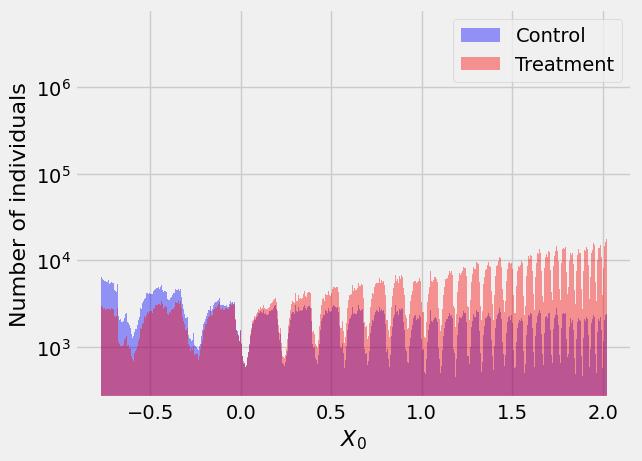

In [22]:
plt.clf()
plt.hist(X[t_biased==0, 2], bins=1000, color='b', alpha=0.4, label='Control')
plt.hist(X[t_biased==1, 2], bins=1000, color='r', alpha=0.4, label='Treatment')
plt.yscale('log')
plt.ylabel('Number of individuals', fontsize=16)
plt.xlabel('$X_0$', fontsize=16)
plt.legend()
plt.show()

## ITE Experiment

In [25]:
def evaluation_synthetic_uplift(n_experiments, model_list, nb_categorical_features_kept, N_data, 
                                treatment_setup, delta, p,
                                synthetic_setup, nb_centers, std_scaler,
                                train_perc, nb_trials, nb_cv):
    
    pickle.dump(model_list, open('RF_experiment_' + str(n_experiments) + '_' + str(N_data) + '_' + synthetic_setup +'_models.pickle', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
    
    ### Initialization
    n_models = len(model_list)
    PEHE_val = np.zeros((n_experiments, n_models))  
    
    ### Load real data from Criteo Dataset
    X_init, t_real, y_real = load_hashed_criteo(nb_categorical_features_kept)
    N, d = X_init.shape
    
    print('d = ' + str(d))
    
    for idx_exp in tqdm(range(n_experiments)):
        
        ### CHOOSE TREATMENT BIAS
        if treatment_setup == 'sigmoid':
            beta_sigmoid = np.zeros(d)
            beta_sigmoid[2] = 1.0
            proba, t = sigmoid_treatment(X_init, beta_sigmoid, delta)
            
        elif treatment_setup == 'binomial':
            t = binomial_treatment(X_init, p)
        
        ### CHOOSE SYNTHETIC SET-UP
        ate_real = 4.0#np.mean(y_real[t_real==1]) - np.mean(y_real[t_real==0])
        noise_scale = ate_real/4.0
        tol = ate_real/100.
        
        if synthetic_setup == 'multi_exp':
            
            y_0, y_1, tau_f = ours_multi_exp(X_init, t, nb_centers, std_scaler, ate_real, noise_scale, tol)

        elif synthetic_setup == 'linear':

            y_0, y_1, tau_f = linear_surface_IHDP(X_init, ate_real, noise_scale)

        elif synthetic_setup == 'exponential':

            y_0, y_1, tau_f = exp_surface_IHDP(X_init, t, ate_real, noise_scale)
        
        t = t.reshape((N,1))
        
        y = y_0*(1-t) + y_1*t
    
        t = t.reshape((N,))
        
        # Random Subsampling
        data_i = np.random.choice(range(N), size=N_data)
        train_i, test_i = data_i[range(int(train_perc*N_data))], data_i[range(int(train_perc*N_data), N_data)]
        
        X_train = X_init[train_i,:].reshape((len(train_i), d))
        y_train = y[train_i].reshape((len(train_i),))
        t_train = t[train_i].reshape((len(train_i),))
        
        X_test = X_init[test_i,:].reshape((len(test_i), d))
        y_test = y[test_i].reshape((len(test_i), ))
        t_test = t[test_i].reshape((len(test_i), ))
    
        ### POOL OF MODELS
        for idx_model in range(n_models): 
            
            dict_current_model = model_list[idx_model]
            print(dict_current_model['name'])
            
            if dict_current_model['type'] == 'BaseEstimator':
                
                model_current = dict_current_model['model']
                
                model_current.fit(X=X_train, 
                                  treatment=t_train, 
                                  y=y_train)
                
                uplift_granular = model_current.predict(X_test)
            
            elif dict_current_model['type'] == 'TARnet':
                
                uplift_granular = crossvalidation_fit_test_predict_TARnet(X_init, y, t, tau_f, train_i, test_i, dict_current_model['params'], nb_trials, nb_cv)
            
            elif dict_current_model['type'] == 'CFRnet':
                
                uplift_granular = crossvalidation_fit_test_predict_CFRnet(X_init, y, t, tau_f, train_i, test_i, dict_current_model['params'], nb_trials, nb_cv)
                        
            ### METRIC EVALUATION
            PEHE_val[idx_exp,idx_model] = pehe(tau_f[test_i].reshape((len(test_i),)), uplift_granular.reshape((len(test_i),)))
        
        np.save('Experiment_' + str(n_experiments) + '_' + str(N_data) + '_' + synthetic_setup +'_PEHE.npy', PEHE_val)
    
    del X_init, t_real, y_real
    
    return PEHE_val

### Parameters

In [26]:
train_perc = 0.5

n_experiments = 10
nb_categorical_features_kept = 5
N_data = 1000000

### Choose treatment setup
treatment_setup = 'sigmoid' # or 'binomial'
p = 0.5
delta = 0.01

### Choose synthetic setup
synthetic_setup = 'multi_exp' # or 'linear' or 'exponential'
nb_centers = 5
std_scaler = 1.0

### Choice of baseline models

In [27]:
### Creating_model_list
model_list = []
nb_cpu = 40
nb_trials = 5
nb_cv = 5

### Hyperparameter space definition
cvt_params_tree = {'max_depth':[1,2,4,8,16]}
cvt_params_RF = {'max_depth':[1,2,4,8], 'n_estimators':[10,20]}
cvt_params_CausalTree = {'max_depth':[1,2,4,8,16], 'min_samples_leaf':[10, 50, 100, 200]}
cvt_params_ridge = {'alpha':[0.1, 1.0, 10.0, 100.0, 1000.0]}
cvt_params_logistic = {'C':[1.0,10.0]}

### Submodel 
RF_learner_TG = RandomizedSearchCV(
        RandomForestRegressor(),
        cvt_params_RF,
        n_iter=nb_trials,
        n_jobs=nb_cpu,
        cv=nb_cv,
    )

Ridge_learner_TG = RandomizedSearchCV(
                        Ridge(),
                        cvt_params_ridge,
                        n_iter=nb_trials,
                        n_jobs=nb_cpu,
                        cv=nb_cv,
                    )

### T Learner
dico_model = {}
dico_model['name'] = 'T-Regressor'
dico_model['type'] = 'BaseEstimator'
dico_model['model'] = BaseTRegressor(learner=RF_learner_TG)
model_list.append(dico_model)

### X Learner
dico_model = {}
dico_model['name'] = 'X-Regressor'
dico_model['type'] = 'BaseEstimator'
dico_model['model'] = BaseXRegressor(learner=RF_learner_TG)
model_list.append(dico_model)

### R Learner
dico_model = {}
dico_model['name'] = 'R-Regressor'
dico_model['type'] = 'BaseEstimator'
dico_model['model'] = BaseRRegressor(learner=RF_learner_TG)
model_list.append(dico_model)

### DR Learner
dico_model = {}
dico_model['name'] = 'DR-Regressor'
dico_model['type'] = 'BaseEstimator'
dico_model['model'] = BaseDRRegressor(learner=RF_learner_TG)
model_list.append(dico_model)


### TARnet
dico_model = {}
dico_model['name'] = 'TARnet'
dico_model['type'] = 'TARnet'
params = {}
params['nb_l'] = [2, 3]
params['nb_u'] = [32, 64]
params['bs'] = [128]
params['lr'] = [1e-3, 1e-5]
params['reg'] = [1e-4, 1e-6]
dico_model['params'] = params
model_list.append(dico_model)

### CFRnet
dico_model = {}
dico_model['name'] = 'CFRnet'
dico_model['type'] = 'CFRnet'
params = {}
params['nb_l'] = [2, 3]
params['nb_u'] = [32, 64]
params['bs'] = [128]
params['lr'] = [1e-3, 1e-5]
params['reg'] = [1e-4, 1e-6]
params['cfr_term'] = [1e-2, 1e-4]
dico_model['params'] = params
model_list.append(dico_model)

### Running experiment

In [ ]:
PEHE_val = evaluation_synthetic_uplift(n_experiments, model_list, nb_categorical_features_kept, N_data, 
                                        treatment_setup, delta, p,
                                        synthetic_setup, nb_centers, std_scaler,
                                        train_perc, nb_trials, nb_cv)

### Results 

In [64]:
PEHE_val = np.sqrt(PEHE_val)
mean_pehe = np.mean(PEHE_val, axis=0)
std_pehe = np.std(PEHE_val, axis=0)
sorted_models = [x for _, x in sorted(zip(mean_pehe, model_list))]
sorted_std = [x for _, x in sorted(zip(mean_pehe, std_pehe))]

In [65]:
sorted_mean = sorted(mean_pehe)
for i in range(len(model_list)):
    print(sorted_models[i]['name'] + " - PEHE : " + str(round(sorted_mean[i],9)) + " +/- " + str(round(sorted_std[i],30)))

CFRnet - PEHE : 0.152471492 +/- 0.03212274250917466
TARnet - PEHE : 0.195430501 +/- 0.04443802520165637
T-Regressor - PEHE : 0.332508682 +/- 0.055622188413029225
R-Regressor - PEHE : 0.356203168 +/- 0.04494315771626078
DR-Regressor - PEHE : 0.379227336 +/- 0.08014386839025717
X-Regressor - PEHE : 0.413417074 +/- 0.1367378228319574
